Plotting transformed images for class: Powdery mildew
Plotting transformed images for class: Healthy
Plotting transformed images for class: Cotton Boll Rot
Plotting transformed images for class: Bacterial blight
Plotting transformed images for class: Aphids


C:\Users\dell\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dell\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\dell/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|█████████████████████████████████████████████████████████████████████████████| 30.8M/30.8M [00:05<00:00, 5.95MB/s]


Epoch 1/1 - Loss: 1.2688 Acc: 0.5884


C:\Users\dell\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


The image is classified as class: Bacterial blight
Execution time: 322.57394194602966 seconds


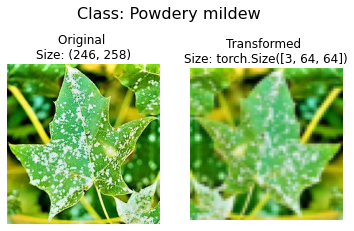

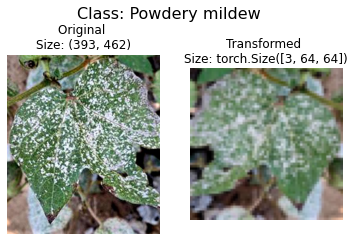

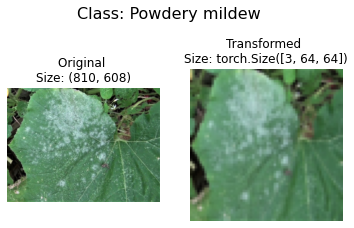

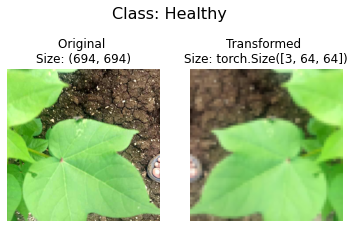

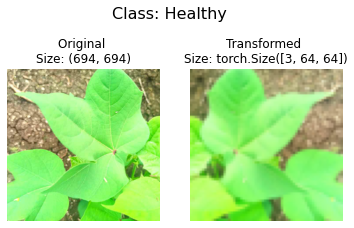

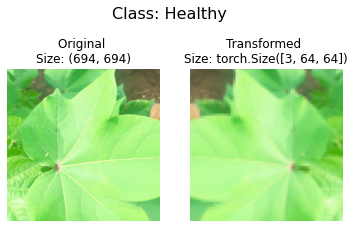

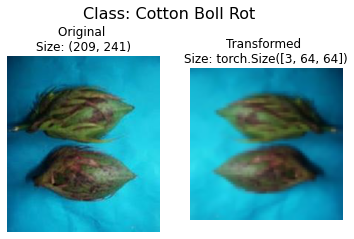

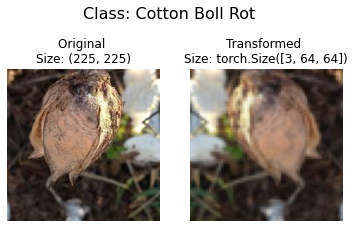

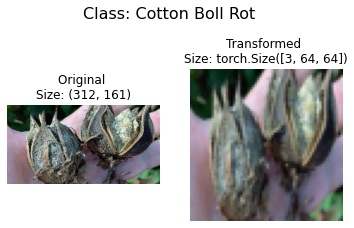

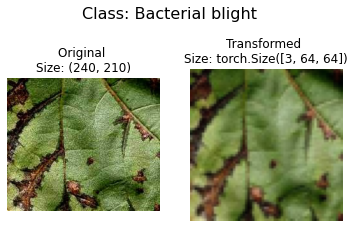

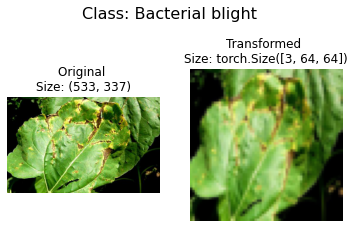

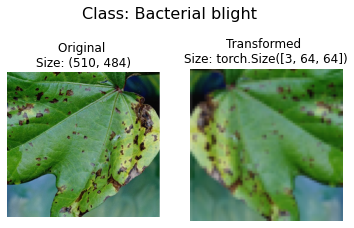

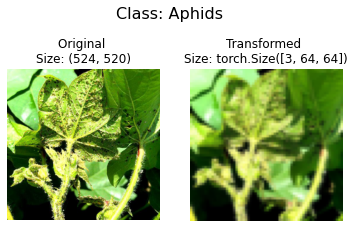

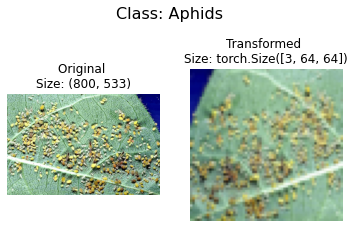

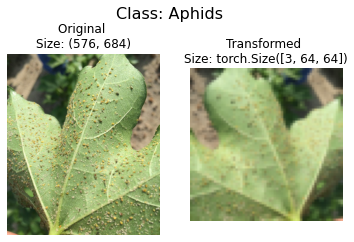

In [1]:
import time
start_time = time.time()
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as img:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(img)
            ax[0].set_title(f"Original \nSize: {img.size}")
            ax[0].axis("off")

            transformed_image = transform(img)
            ax[1].imshow(transformed_image.permute(1, 2, 0))
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            class_name = os.path.basename(os.path.dirname(image_path))
            fig.suptitle(f"Class: {class_name}", fontsize=16)

data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

main_folder = "E:\\Cotton-Disease-Training\\trainning\\Cotton leaves - Training\\800 Images"

classes = ["Powdery mildew", "Healthy", "Cotton Boll Rot", "Bacterial blight", "Aphids"]
class_to_idx = {cls: i for i, cls in enumerate(classes)}

class_images = {cls: [] for cls in classes}

for cls in classes:
    class_folder = os.path.join(main_folder, cls)
    for filename in os.listdir(class_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(class_folder, filename)
            class_images[cls].append(img_path)

image_path_list = {cls: images for cls, images in class_images.items()}

for cls in classes:
    print(f"Plotting transformed images for class: {cls}")
    plot_transformed_images(image_path_list[cls], transform=data_transform, n=3)

train_data = datasets.ImageFolder(root=main_folder, transform=data_transform)
class_names = train_data.classes

train_dataloader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

# Use DenseNet-121 architecture
model = models.densenet121(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier.requires_grad = True
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    corrects = 0

    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_data)
    epoch_acc = corrects.double() / len(train_data)

    print(f'Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

# Save the fine-tuned model
torch.save(model.state_dict(), "first_tuned_model_densenet_cotton_disease.pth")

# Testing phase
test_image_path = "E:\\Cotton-Disease-Training\\trainning\\Cotton leaves - Training\\cotton_segment.jpg"
test_image = Image.open(test_image_path)

data_transform_test = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

transformed_test_image = data_transform_test(test_image)
transformed_test_image = transformed_test_image.unsqueeze(0)

# Create a new model for testing
model_test = models.densenet121(pretrained=False)
num_ftrs_test = model_test.classifier.in_features
model_test.classifier = nn.Linear(num_ftrs_test, len(class_names))  # Ensure the number of classes matches the original configuration
model_test.load_state_dict(torch.load("first_tuned_model_densenet_cotton_disease.pth"))
model_test.eval()
transformed_test_image = transformed_test_image.to(device)
model_test = model_test.to(device)

with torch.no_grad():
    outputs_test = model_test(transformed_test_image)
    _, predicted_test = torch.max(outputs_test, 1)

predicted_class_test = class_names[predicted_test.item()]
print(f"The image is classified as class: {predicted_class_test}")

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Execution time: {elapsed_time} seconds")
